### Preprocessing

- exclude useless features (constants/trivials)
- divide features in categorical/quantitative
- fill missing values
    - `intensity` is estimated using `std`
    - `NaN` values for other features are converted to -1

In [1]:
import pandas as pd
import intensity_fill

df = pd.read_csv("ravdess_features.csv")

excluded = [
    "modality",
    "channels",
    "frame_rate",
    "frame_width",
    "sample_width",
    "stft_max",
    "frame_count",
    "length_ms",
]
# Features' exclusion
df.drop(columns=excluded, inplace=True)

# Categotical/quantitative division
categorical = ["sex", "emotion", "emotional_intensity", 
                "vocal_channel", "statement", "actor",
                "repetition", 
                #"channels", "sample_width",
            ]
quantitative = [feature for feature in df.columns if not feature in categorical]


# Conversion to categorical codes
cat_id = dict(zip(categorical, categorical))
for field in categorical:
    # Sets NaN to nont available (new category)
    df[field].fillna("N/A", inplace=True)
    df[field] = pd.Categorical(df[field])
    # Saves categorical mapping
    cat_id[field] = dict(enumerate(df[field].cat.categories ))
    df[field] = pd.Categorical(df[field]).codes

# Fill intensity
df = intensity_fill.fill_intensity(df)
df.sort_values(by=['sex'], inplace=True)

with pd.option_context('display.max_rows', 10, 'display.max_columns', None):  # more options can be specified also
    display(df)

/home/djanloo/Desktop/dynamiting/intensity_fill.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.intensity[df.intensity.isna()] = I_from_std(df["std"][df.intensity.isna()])


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,2,3,0,0,1,1,0,-36.793432,16995,-33.485947,134.65486,-755.22345,171.69092,5792.550744,3328.055457,0.000000,13541.959028,-1.120769,0.250940,0.415250,0.335533,0.000000,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1375,1,6,1,0,0,24,0,-40.269564,16489,-34.619278,136.26785,-761.73740,181.54887,5164.904857,3522.028486,0.000000,11472.046043,-1.295199,0.404622,0.392226,0.361055,0.000000,-1.385993,0.385389,-3.165859e-07,0.009627,-0.068512,0.073395,6.102265,-0.090852
1374,2,1,0,0,1,13,0,-49.721323,8789,-38.187992,169.99434,-906.66455,156.91988,5924.956667,4178.457432,0.000000,12542.196013,-1.558270,-0.011740,0.447439,0.365072,0.000000,-1.539062,0.061047,-1.186637e-06,0.003270,-0.026917,0.030334,10.679748,0.027419
1373,2,0,0,0,1,24,0,-37.796119,14897,-32.179874,138.91797,-757.35430,208.45117,6665.537707,3987.299294,0.000000,14326.799071,-1.587733,-0.193415,0.523385,0.338170,0.000000,-1.367812,-0.143104,-1.723407e-07,0.012798,-0.094208,0.103699,8.532281,-0.051235
1372,2,3,0,0,0,9,0,-38.053322,17980,-28.537954,139.94365,-761.61530,190.70274,5799.776716,3099.713279,1044.318674,13785.338437,-1.166613,0.139954,0.465281,0.334768,0.000205,-1.329112,0.144841,3.019958e-08,0.012529,-0.082764,0.080109,6.517363,-0.161805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2,5,0,0,1,16,1,-41.881562,8508,-24.981382,153.38182,-805.57837,253.42377,5009.979889,2896.771574,649.673800,10110.463129,-1.465159,-0.159068,0.568964,0.298337,0.007136,-1.262947,-0.109651,2.714347e-06,0.007996,-0.060730,0.081177,14.546931,-0.221025
486,1,6,1,0,1,24,1,-28.674853,15371,-18.568733,107.59378,-659.06460,196.14836,3519.539752,2731.708448,801.191145,12036.748017,0.915322,1.371468,0.420108,0.331103,0.001080,-1.193291,0.380473,6.826411e-06,0.036849,-0.206482,0.240112,4.348387,-0.037049
487,2,7,0,1,0,4,1,-43.947732,12917,-29.123283,150.71290,-803.47650,236.95813,6352.799828,3744.650178,854.446207,11745.879422,-1.592407,-0.137680,0.593119,0.318111,0.000547,-1.152702,-0.442880,-9.226098e-07,0.006357,-0.078735,0.075958,18.570233,-0.373361
479,2,5,0,0,1,14,1,-42.324899,9203,-26.372047,154.93830,-824.11273,236.61170,5479.811405,3169.197746,862.664655,11533.363243,-1.424242,-0.115265,0.610178,0.301083,0.012729,-1.087910,-0.433776,2.057694e-06,0.007598,-0.089661,0.094818,21.929256,-0.651609


### Normalization

In [3]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

scaler = QuantileTransformer()

X = df[quantitative].values
X = scaler.fit_transform(X)

Manifold knn representation

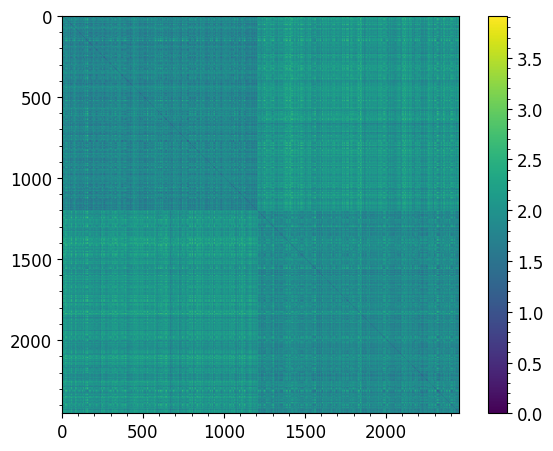

In [4]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
k = len(X)
A = kneighbors_graph(X,k, mode='distance', include_self=True)
adj = A.toarray()
plt.imshow(adj)
plt.colorbar()

This shows that the distances in the male subgroup are smaller than the inter-group average distance.

(-2.270445687424983, 2.2584289325229667, -2.4292354765436497, 2.25628297241663)

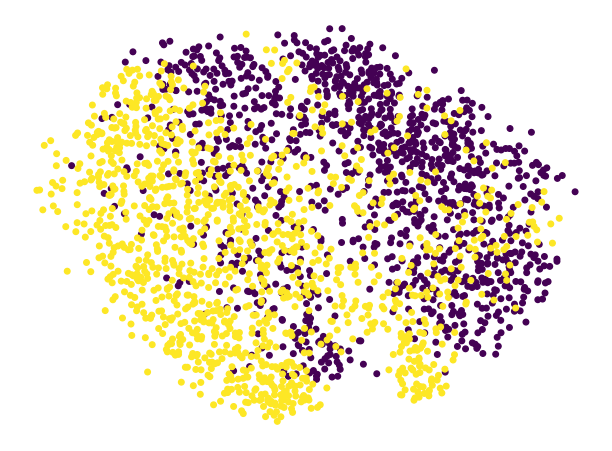

In [11]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2).fit_transform(X)

plt.scatter(embedding[:,0], embedding[:,1], c=df.sex)
plt.axis("off")


Text(0.5, 0.98, 'MultiDimensional Scaling')

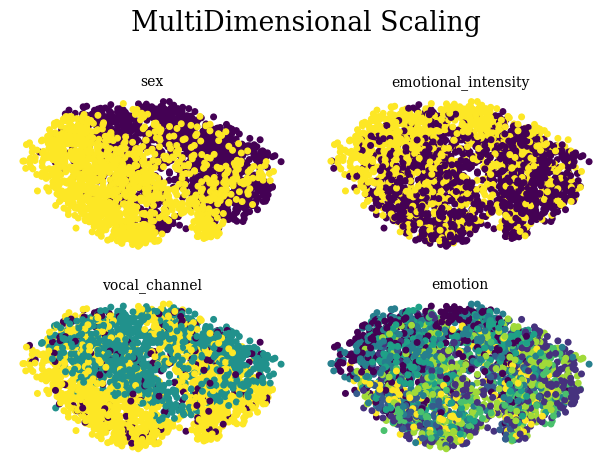

In [20]:
fig, axes = plt.subplots(2,2)
axes = axes.flatten()
fields = ["sex", "emotional_intensity", "vocal_channel", "emotion"]
for ax, field in zip(axes, fields):
    ax.scatter(embedding[:,0], embedding[:,1], c=df[field])
    ax.set_title(field, font={"size":10, "family":"serif"})
    ax.axis("off")
fig.suptitle("MultiDimensional Scaling", font={ "family":"serif"})

# UMAP

(-6.549592924118042,
 15.123042058944701,
 -3.1028799772262574,
 11.03276822566986)

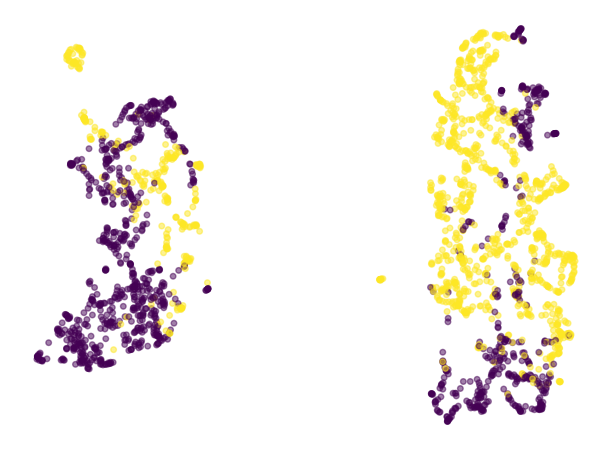

In [7]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import umap 

X = df[quantitative].values
scaler = QuantileTransformer() # MinMaxScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=5)
embedding = reducer.fit_transform(X)
plt.scatter(embedding[:,0], embedding[:,1], c=df.sex, alpha=0.5)
plt.axis("off")

IndexError: list index out of range

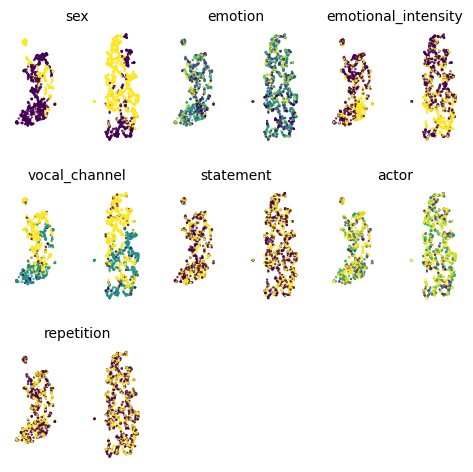

In [8]:
fig, axes = plt.subplots(3,3 , figsize=(5,5))
axes = axes.flatten()

for ax in axes:
    ax.axis("off")

for i in range(len(axes)):
    axes[i].scatter(embedding[:,0], embedding[:,1], c=df[categorical[i]], alpha=0.8, s=0.5)
    axes[i].set_title(f"{categorical[i]}", font={"size":10})


We drop the analysis of `repetition`, `actor` and `statement` by now

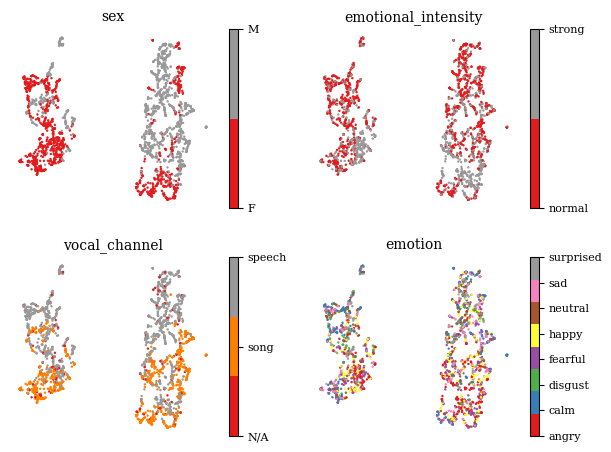

In [ ]:
from matplotlib import cm

good_ones = ["sex", "emotional_intensity", "vocal_channel", "emotion"]

fig, axes = plt.subplots(2,2)
axes = axes.flatten()

for ax, cat in zip(axes, good_ones):
    cmap = cm.get_cmap("Set1", len(cat_id[cat]))
    mappable = ax.scatter(embedding[:,0], embedding[:,1], c=df[cat],
                cmap=cmap, alpha=1.0, s=0.5)
    ax.set_title(f"{cat}", font={"size":10, "family":"serif"})
    cbar = fig.colorbar(mappable, ax=ax)
    cbar.ax.set_yticks(list(cat_id[cat].keys()))
    cbar.ax.set_yticklabels(cat_id[cat].values(), font={"size":8, "family":"serif"})
    cbar.ax.tick_params(axis='y', which='minor', right=False)
    ax.axis("off")
fig.tight_layout()
plt.savefig("UMAP.pdf")
